# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Построим модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке.

Дополнительно измерим AUC-ROC, сравнивайте её значение с F1-мерой.

## 1. Загрузим и подготовим данные. Поясним порядок действий.

In [415]:
# Импортируем библиотеки

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [416]:
# Читаем файл csv

data = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/6/[Boominfo.org] ЯП специалист дата часть6 (2022)/Часть 6/07 Самостоятельный проект/Churn.csv')

In [417]:
# Посмотрим информацию о данных

display(data.head())
display(data.info())
display(data.isna().sum())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [418]:
# Посмотрим есть ли большая разница 
# между средним и медианой в колонке 'Tenure'

data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [419]:
# Заменим пустые значения в колонке 'Tenure'
# на медиану

data['Tenure'] = data['Tenure'].fillna(5)

In [420]:
# Удалим не нужные для обучения модели столбцы

data.drop(['RowNumber','CustomerId','Surname'], axis = 1, inplace = True) 

In [421]:
# Посмотрим сколько уникальных значений 
# в столбцах типа 'object'

for i in data.columns:
    if data[str(i)].dtype == 'object':
        print(i, data[str(i)].nunique())

Geography 3
Gender 2


In [422]:
# Масштабируем признаки

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [423]:
# Преобразуем колонку Geography и Gender техникой OHE
# к колонке Gender применим get_dummies() 
# чтобы избежать дамми-ловушки
# Разбобьем исходные данные на две выборки в соотношении 75:25 (%)

data_ohe = pd.get_dummies(data, prefix=['Geography'], columns=['Geography'])
data_ohe = pd.get_dummies(data_ohe, drop_first=True)
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, train_size=0.6, test_size=0.4, random_state=12345)
)
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)
)

In [424]:
features_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8532 to 6895
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2000 non-null   float64
 1   Age                2000 non-null   float64
 2   Tenure             2000 non-null   float64
 3   Balance            2000 non-null   float64
 4   NumOfProducts      2000 non-null   int64  
 5   HasCrCard          2000 non-null   int64  
 6   IsActiveMember     2000 non-null   int64  
 7   EstimatedSalary    2000 non-null   float64
 8   Geography_France   2000 non-null   uint8  
 9   Geography_Germany  2000 non-null   uint8  
 10  Geography_Spain    2000 non-null   uint8  
 11  Gender_Male        2000 non-null   uint8  
dtypes: float64(5), int64(3), uint8(4)
memory usage: 148.4 KB


<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## 1. Вывод подготовки данных
        
       
1. Заменили пропуски в столбце Tenure на медиану.
        
2. Удалили столбцы RowNumber, CustomerId и Surname. Так как они не влияют на результат.
        
3. Преобразовали колонки Geography и Gender техникой One Hot Encoding
        
4. Масштабируем признаки в колонках CreditScore, Age, Tenure, Balance и EstimatedSalary.

## 2. Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишием выводы.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<Axes: >

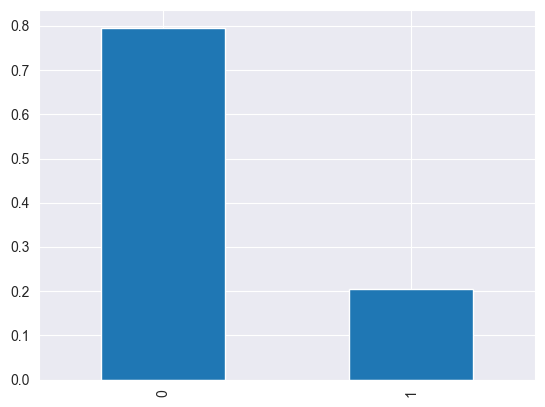

In [425]:
# Посмотрим баланс классов

class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

In [426]:
# Обучим модель логистической регрессии

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = pd.Series(model.predict(features_valid))

f1_valid = f1_score(target_valid, predicted_valid)

print('F1:', f1_valid)

F1: 0.33108108108108103


0    0.913
1    0.087
dtype: float64


<Axes: >

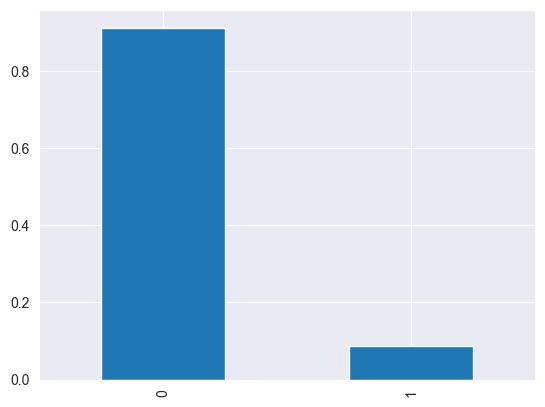

In [427]:
# Посмотрим баланс классов предсказания

class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## 2. Вывод исследования баланса классов
        
Баланс в 4 раза смещен в сторону класса '0'. После обучения модели логистической регрессии, баланс сместился еще сильнее, в 9 раз.

## 3. Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Кратко опишем выводы.

### 3.1 Улучшим качество модели, учитывая дисбаланс классов.

In [428]:
# Добавляем баланс классов в LogisticRegression модель 

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_valid = f1_score(target_valid, predicted_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4888507718696398


In [429]:
# Увиличиваем размер класса '1'

def upsample(features, target, repeat):
    features_zeros = features_train[target == 0]
    features_ones = features_train[target == 1]
    target_zeros = target_train[target == 0]
    target_ones = target_train[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = LogisticRegression(solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5


In [430]:
# Уменьшаем размер класса '0' с добавлением баланса классов

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4866723989681858


### 3.2 Обучим разные модели и найдем лучшую

In [471]:
# Обучим модель RandomForestClassifier

best_f1_valid = 0
best_depth = 0
best_est = 0

for depth in range(1, 16, 1):
    model = RandomForestClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1_valid = f1_score(target_valid, predicted_valid)
    if f1_valid > best_f1_valid:
        best_f1_valid = f1_valid
        best_depth = depth
        
for est in range(10, 101, 10):
    model = RandomForestClassifier(n_estimators=est, max_depth=best_depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1_valid = f1_score(target_valid, predicted_valid)
    if f1_valid > best_f1_valid:
        best_f1_valid = f1_valid
        best_est = est

print('F1:', best_f1_valid)
print('max_depth:', best_depth)
print('n_estimators:', best_est)

F1: 0.6285714285714286
max_depth: 8
n_estimators: 30


In [472]:
# Увиличиваем размер класса '1'

def upsample(features, target, repeat):
    features_zeros = features_train[target == 0]
    features_ones = features_train[target == 1]
    target_zeros = target_train[target == 0]
    target_ones = target_train[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6189376443418014


In [473]:
# Уменьшаем размер класса '0'

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5944391179290508


<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## 3. Вывод обучения разных моделей
        
Сравнили 2 модели: Logistic Regression и Random Forest Classifie. Лучшей оказалась Random Forest Classifie с глубиной деревьев 8 и колличеством деревьев 30, а так же со встроенным балансом классов.

# 4. Проведем финальное тестирование.

In [486]:
# Проверим лучшую модель на тестовой выборке

model = RandomForestClassifier(n_estimators=30, max_depth=8, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

print('F1:', f1_score(target_test, predicted_test))
print('Accuracy:', accuracy_score(target_test, predicted_test))

F1: 0.6073752711496746
Accuracy: 0.819


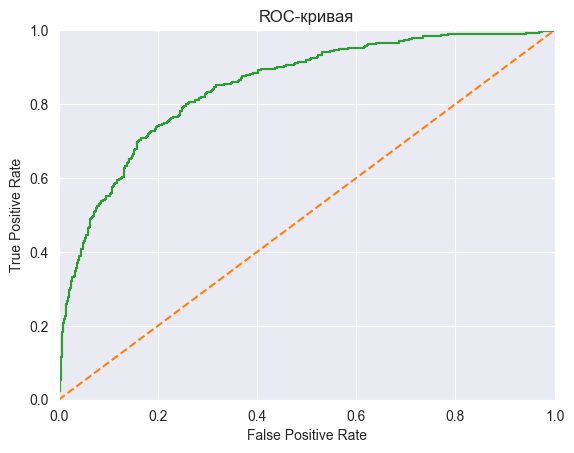

Площадь под ROC-кривой: 0.8464796101164643


In [482]:
# Строим ROC-кривую
# Считаем площадь под ROC-кривой

probabilities_test = model.predict_proba(features_test) 
probabilities_one_test = probabilities_test[:, 1] 
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

print('Площадь под ROC-кривой:', roc_auc_score(target_test, probabilities_one_test))

<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## Общий вывод
        
1. Лучшей моделью оказалась Random Forest Classifie с глубиной деревьев max_depth=8 и колличеством деревьев n_estimators=30. Результат F1 на тестовой выборке: 0.61.
2. Встроенный праметр баланса классов class_weight='balanced' работает лучше, чем upsample и downsample.
3. Площадь под ROC-кривой: 0.85, что говорит о высоком качестве модели.
4. Accuracy: 0.82

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
